# 2D Bin Packing with a Genetic Algorithm

This is a follow up to a previous notebook where I used a guillotine heuristic to solve a 2D bin packing problem.  In my previous notebook, I sorted the parts by descending area before applying the guillotine heuristic. As I pointed out, this sorting choice can have a significant impact on packing performance.  I've used genetic (evolutionary) optimization algorithms (GA) in other applications and thought they might be effective in solving the bin packing problems.   GA overcomes the sorting dilemma by randomly trying many different orderings of the parts.  
  
<img src="./images/genetics-clip-art.png"  width="400" height="300" style="transform:rotate(90deg);" />

## Genetic Algorithms
The basic ideas and steps in genetic optimization are:
1. **Create an intial population**.  Parts are randomly sampled from the original parts list (without replacement) then some are rotated based on chance.  This is repeated until $N_{pop}$ parts lists have been created. This collection of ordered parts lists is called a population.  
2. **Evaluate this poulation for fitness**.  Each parts list is provided to a bin packing heuristic and fitness is determined using a packing score. Part rotation is allowed during initial parts list creation and subsequent iterations.
3. **Rank this population by fitness**.
4. **Determine the mating pool**.  For example, choose the 2 parts lists with the best fitness. 
5. **Create offspring (a new generation or population) from the selected parents via crossover and mutation**.  In my code crossover means swapping a randomly chosen segment of the parts list from parent A to B.  In my code mutation means for each part in the list, generate a random number, if it is below some threshold, rotate the part.
6. **Repeat steps 2-5** for the desired number of generations.
  
There are many variations used for the steps above.  From what I've seen there are no "standard" genetic codes.  You need to tailor these steps to your optimization problem.  There is also a parameter tuning aspect to genetic algorithms (GA) that should be noted.  For example, how many generations is enough?  How big should I make my population?  There are no hard and fast rules for these so experimentation is needed.  

## Guillotine Packing
I'm using the same guillotine bin packing heuristic from the earlier notebook to evaluate the fitness of each ordered part list.  Some key differences:
1. No pre-sorting is used.  The order of the parts is determined by the GA. 
2. Onlly one fit_method = ['BAF'] and one split method ['MINAS'] are used. 

In [20]:
import operator
import datetime
import random
import copy
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm


def import_parts(part_file, kerf=0):
    """Import list of parts to be packed or cut from a CSV file. (float dims)
    
    Parameters
    ----------
    part_file : string
        file name (including path if necessary) of comma separated part file. 
        First line of part_file contains a descriptive name for the test case or
        problem being solved.  Second line has the bin width and height.
        Remaining lines in file have part_ID, width, length and quantity for 
        each part definition. Part quantities must be < 100 to work with
        renumbering scheme. When quantity > 1, part ID n is exploded into
        part ID n01, n02, etc. since each row in parts must have a unique
        part ID. This renumbering can be removed post-solution if desired. 
    kerf : float
        optional saw blade thickness allowance. Accounts for the material 
        lost to cutting.

    Returns
    -------
    test, string
        Description of test case or problem
    bin_W, float
        width of sheet/container/bin increased by 1 kerf
    bin_L, float
        height of sheet/container/bin increased by 1 kerf
    parts, array
        part data with columns for part_ID, width, length and area


    part_file example
    -------
    Hopper & Turton Cat 1-1
    20, 25
    0, 2, 12, 1
    1, 7, 12, 1

    """
    f = open(part_file, 'r', encoding='utf-8-sig')
    x = f.readlines()
    f.close()

    test = x[0].strip()
    bin_W = float(x[1].split(',')[0]) + kerf
    bin_H = float(x[1].split(',')[1]) + kerf
    data = []
    cols = len(x[2].split(','))

    if cols == 3:
        for i in range(2, len(x)):
            xx = list(map(float, x[i].split(',')))
            data.append([int(xx[0]), xx[1], xx[2], xx[1] * xx[2]])

    else:  # cols > 3 means each row has a quantity value.
        for i in range(2, len(x)):
            xx = list(map(float, x[i].split(',')))
            qty = int(xx[3])
            if qty > 99:
                raise ValueError("Part qty > maximum of {}".format(99))
            if qty == 1:
                data.append([int(xx[0]), xx[1], xx[2], xx[1] * xx[2]])
            else:
                for i in range(qty):
                    data.append([int(100 * xx[0] + i + 1), xx[1],
                                 xx[2], xx[1] * xx[2]])

    parts = np.array(data)
    
    if kerf > 0:
        for part in parts:
            part[1] += kerf
            part[2] += kerf

    return test, bin_W, bin_H, parts


part_file = "../bin_packing/Test_Case_Rectangular.csv"
kerf = .125  # saw blade allowance
# read part list data
test_name, sht_width, sht_height, part_list = import_parts(part_file, kerf)
case_source = test_name.split('_')[0] 
npop = len(part_list)
# trim PL
parts = part_list[:, 0:3]
num_parts = parts.shape[0]

The source file is the same as in the previous notebook so I will not dwell on it. 

There are several methods used to support the guillotine packing algorithm (same as previous notebook).

In [21]:
def recursive_merge(inter, start_index = 0):
    """
    recursive merge to remove overlapping ranges

    Parameters
    ----------
    inter : list
        list of tuples defining ranges. e.g.[(0,10), (5,20), (30,40)]
    start_index : int, optional
        starting index for merging. The default is 0.

    Returns
    -------
    list
        merged intervals.

    """
    inter_ = copy.copy(inter)
    for i in range(start_index, len(inter_) - 1):
        if inter_[i][1] > inter_[i+1][0]:
            new_start = inter_[i][0]
            new_end = max(inter_[i][1], inter_[i+1][1])
            inter_[i] = (new_start, new_end)
            del inter_[i+1]
            return recursive_merge(inter_.copy(), start_index=i)

    return inter_ 

In [22]:

def rect_merge(free_rectangles, pattern, sht_width, sht_height):
    """
    Merge Rectangles Improvement. Check all free rectangles to see if any
    neighboring free rectangles can be exactly represented as single
    larger free rectangle.

    Parameters
    ----------
    free_rectangles : list
        list of free rectangles.
    pattern : array
        array of packed parts for a bin [id, w, h, area, x, y]

    Returns
    -------
    merged_rectangles : set
        merged set of free rectangles.

    """
    merged_rectangles = set(free_rectangles)
    merged = True
    
    while merged==True:
        if len(merged_rectangles) <= 1:  # nothing to merge
            return list(merged_rectangles)
        
        # determine all the combinations of pairs in merged rectangles.   
        combos = combinations(merged_rectangles, 2)
    
        for (f1, f2) in combos:
            if f1.x==f2.x2 and f1.y==f2.y and f1.y2==f2.y2:
                # merge f1 and f2 (left edge)
                new_rect = Rect(f1.ID, f1.w + f2.w, f1.h, f2.x, f2.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break
            
            elif f1.y==f2.y2 and f1.x==f2.x and f1.x2==f2.x2:
                # merge f1 and f2 (bottom edge)
                new_rect = Rect(f1.ID, f1.w, f1.h + f2.h, f2.x, f2.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            elif f1.x2==f2.x and f1.y==f2.y and f1.y2==f2.y2:
                # merge f1 and f2 (right edge)
                new_rect = Rect(f1.ID, f1.w + f2.w, f1.h, f1.x, f1.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            elif f1.y2==f2.y and f1.x==f2.x and f1.x2==f2.x2:
                # merge f1 and f2 (top edge)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(Rect(f1.ID, f1.w, f1.h + f2.h, f1.x, f1.y))
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            else:
                merged = False

    return list(merged_rectangles)

In [23]:
def check_merged(free_rects, pattern, sht_width, sht_height):
    """
    Tests merged free rectangles to insure the resultant pattern will
    still be guillotineable.

    Parameters
    ----------
    free_rects : list
        list of Rect objects .
    pattern : array
        array of packed parts each row has [id, w, l, x, y].

    Returns
    -------
    check_OK : tuple
        boolean True = pass, bin_index of failing pattern.

    """
    pattern2 = copy.deepcopy(pattern)
    check_OK = False
    # add free rects to pattern as parts
    j = 1000
    for rect in free_rects:
        pattern2 = np.append(pattern2, [[j, rect.w, rect.h, rect.area,
                                         rect.x, rect.y]], axis=0)
        j += 1
    # check this pattern for guillotine-ability
    check_OK = check_cuts([pattern2], sht_width, sht_height)
    
    return check_OK

In [24]:
def check_cuts(bins, sht_width, sht_height):
    """
    Check bins for guillotine cut compliance.

    Parameters
    ----------
    bins : list
        list of arrays defining packed bins.
        has rows with  [part_ID, w, h, area, x1, y1]
    sht_width : int or float
        sheet width (x axis)
    sht_height : int or float
        sheet height (y axis)
        
    Returns
    -------
    boolean 
        True if all bins meet guillotine cutting requirement
    int
        index of first bin that fails guillotine cutting check

    """
    for i, binx in enumerate(bins):
        patt = np.empty((0, 5))
        # array of packed parts (partID, x1, y1, x2, y2 )
        for item in binx:
            patt = np.append(patt, [[item[0], item[4], item[5],
                                       item[1] + item[4],
                                       item[2] + item[5]]], axis=0)

        extents = [0, 0, sht_width, sht_height]  # sheet dimensions
    
        status, cuts = split_pattern(patt, extents, [])
        if not status:
            return False, i
            
    return True, None

In [25]:
def split_pattern(pattern, extents, cuts):
    """
    attempt to find a guillotine cut for pattern

    Parameters
    ----------
    pattern : array
        array of rectangles in a pattern. [id, x, y, x2, y2]
    extents : list
        pattern extents, [x1, y1, x2, y2], lower-left and upper-right corners
    cuts : list
        list of tuples containing axis and value for guillotine cuts

    Returns
    -------
    status : boolean
        True if pattern is guillotineable, False if not
    cuts : list
        possibly updated list of guillotine cuts

    """

    if len(pattern) == 1:  # only one rectangle in pattern
        return True, cuts
    
    # determine horiz intervals  e.g. (0,22), (15,33), ...
    horiz_intervals = []
    pattern_x = pattern[pattern[:, 1].argsort()] # pattern.sorted by x
    for i, r in enumerate(pattern_x):
        horiz_intervals.append( (r[1], r[3]) )   
    
    # merge horizontal intervals
    merged_intervals = recursive_merge(sorted(horiz_intervals))

    if len(merged_intervals) > 1:
        horiz = True
        x_cut = merged_intervals[1][0]
        cut_info = [(x_cut, extents[1]), (x_cut, extents[3])]
        cuts.append(cut_info)
 
        # create 2 sub patterns  
        pattern1 = pattern[pattern[:,1] < x_cut]
        ext1 = [extents[0], extents[1], x_cut, extents[3]]
        pattern2 = pattern[pattern[:,1] >= x_cut]
        ext2 = [x_cut, extents[1], extents[2], extents[3]]
        
        for pattern, ext in [(pattern1,ext1), (pattern2, ext2)]:
            status, cuts = split_pattern(pattern, ext, cuts) # recursive call
            if status is False:
                return False, cuts
    else:
        horiz = False  # boolean to indicate horiz split happened
            
    # determine vertical intervals  e.g. (0,22), (15,33), ...
    vert_intervals = []
    pattern_y = pattern[pattern[:, 2].argsort()] # pattern sorted by y
    for i, r in enumerate(pattern_y):
        vert_intervals.append( (r[2], r[4]) )   
    
    # merge vertical intervals   
    merged_intervals = recursive_merge(sorted(vert_intervals))
    if len(merged_intervals) > 1:
        y_cut = merged_intervals[1][0]
        cut_info = [(extents[0], y_cut), (extents[2], y_cut)]
        cuts.append(cut_info)
        
        # create 2 new patterns  
        pattern1 = pattern[pattern[:,2] < y_cut]
        ext1 = [extents[0], extents[1], extents[2], y_cut]
        pattern2 = pattern[pattern[:,2] >= y_cut]
        ext2 = [extents[0], y_cut, extents[2], extents[3]]
        
        for pattern, ext in [(pattern1,ext1), (pattern2, ext2)]:
            status, cuts = split_pattern(pattern, ext, cuts) # recursive call
            if status is False:
                return False, cuts
            
    elif horiz==False:  # horizontal and vertical splits failed
        status = False
        
    return status, cuts

In [26]:
class Rect():
    """Rectangle class for 2D bin packing"""
    ID = ''
    w = 0
    h = 0
    x = 0 
    y = 0
    
    def __init__(self, ID, w, h, x, y):
        """initialize a Rectangle"""
        self.ID = ID
        self.w = w
        self.h = h
        self.x = x
        self.y = y
        self.area = self.w * self.h
        self.x2 = self.x + self.w
        self.y2 = self.y + self.h
        self.ss = min(self.w, self.h)
        self.ls = max(self.w, self.h)
        self.rect = self.ID, self.w, self.h, self.x, self.y

    def __repr__(self):
        return "\nRect( ID:{}   x,y:{},{}   w,h:{},{}".format(
                self.ID, self.x, self.y, self.w, self.h)
    
    def __str__(self):
        return 'Rect(ID:' + self.ID + ', width:' + self.w + \
                ', height:' + self.h + ', x:' + self.x + ', y:' + self.y + ')'
                
    def __hash__(self):
        return hash(self.rect)
    
    def __eq__(self, other):
        if isinstance(other, Rect):
            return self.rect == other.rect
        return NotImplemented

In [27]:
def packing_score(bins, sht_width, sht_height):
    """
    Calculate a packing score to indicate largest leftover portion of any bin.
 
    Parameters
    ----------
    bins : list of 2D arrays
        Set of packed bins. Each bin is an array with rows containing 
        [part_ID, w, h, area, x, y]
    sht_width : float
        Width (horizontal) of sheet
    sht_height : float
        Height (vertical) of sheet
        
    Returns
    -------
    float
        packing score
        
    score = nbins - max(a1, a2)/sht_area
    
    a1 and a2 are the full span areas at the top or right of the bin. 
    headroom is the unused portion at the top of the bin, elbowroom
    is the unused portion of the right side of the bin.
    
    This score is motivated by a desire to maximize the full span
    leftover portion on one of the bins. The leftover portion being
    more "useable" for future projects.
    Also, this metric gives a measure of how tightly the bins are packed
    instead of simply using the number of sheets required.
    
    """
    nbins = len(bins)
    best_score = nbins  # initialize
    
    for binx in bins:
    
        headRoom = sht_height - np.max(np.add(binx[:, 5],
                                              binx[:, 2]))
        a1 = headRoom * sht_width
        
        elbowRoom = sht_width - np.max(np.add(binx[:, 4],
                                              binx[:, 1]))
        a2 = elbowRoom * sht_height
        
        score = nbins - max(a1, a2) / (sht_height * sht_width)
        
        if score < best_score:
            best_score = score
    
    return best_score

In [28]:
def calc_score(parts, sht_width, sht_height, kerf):
    """Pack rectangles, in the order provided, into free rectangles and sheets
    using a guillotine 2d bin packing heuristic.

    Parameters
    ----------
    parts : 2D array
        rectangular parts to be packed/cut. Each row has
        part_ID, width, length and area.
        
    sht_width : float
        Sheet width
    sht_height : float
        Sheet height
    kerf : float
        Saw blade thickness allowance

    Returns
    -------
    score : float
        fitness score for bin packing. The number of full sheets used minus
        the largest unused portion of width or height.
    bins : list
        list of packed bin arrays. Arrays have rows with rect_ID, rect_width,
        rect_height, rect_area, x1 and y1. Where x1, y1 are the lower left
        corner for the rect placement.

    """
    rotation = True  # rectangles may be rotated during packing
    best_score = len(parts) # initialize to a worst case value

    bins = [np.empty((0,6))]  # initialize first bin
    free_rects = [[Rect('f0', sht_width, sht_height, 0, 0)]]
    k = 1 # initialize unique identifier for free rectangles

    for part in parts:
        p = Rect(part[0], part[1], part[2], 0, 0) # for convenience
        # initialize:
        f = None  # selected free rect
        dA = sht_height * sht_width  # init leftover area
        dls = max(sht_width, sht_height)  # init leftover long side
        dss = dls  # init leftover short side

        for j, _bin in enumerate(bins):
            # try part in all bins and free rects to see if any fit and 
            # identify the bin and free rect with the best fit. 
            # for this part, which free rect fits best?
            for i, fi in enumerate(free_rects[j]):
                # does part fit in fi ?
                if p.h <= fi.h and p.w <= fi.w:
                    w, h = p.w, p.h
                    # does part fit better in fi?            
                    if fi.area - p.area < dA:  # fit=BAF
                        f = fi
                        dA = fi.area - p.area
                        bin_idx = j
                        rotated = False

                if rotation and p.w <= fi.h and p.h <= fi.w:
                    w, h = p.h, p.w                 
                    if fi.area - p.area < dA:  # fit = BAF
                        f = fi
                        dA = fi.area - p.area
                        bin_idx = j
                        rotated = True

                else: continue                    

            if f == None: # part doesnt fit in any free rect in this bin
                continue # next bin

        if f == None:  # part doesnt fit in any free rect in any bins
            # open a new bin
            bins.append(np.empty((0,6)))
            bin_idx = len(bins) - 1

            free_rects.append([Rect('f0', sht_width, sht_height, 0, 0)])
            f = free_rects[bin_idx][0]

        #decide orientation for part
        if rotated:
            p.w, p.h = p.h, p.w

        # place part at bottom-left of f in bin[j]
        bins[bin_idx] = np.append(bins[bin_idx], [[p.ID, p.w, p.h,
                                                   (p.w-kerf) * (p.h-kerf),
                                                   f.x, f.y]], axis=0)

        # Subdivide Fi into Fp and Fpp (split rule)
        # split=="MINAS":  # minimum area split
        a1 = p.h * (f.w - p.w)
        a2 = p.w * (f.h - p.h)
        if a1 > a2: # split vert
            fp = Rect('f' + str(k), p.w, f.h - p.h, f.x, f.y + p.h)
            fpp = Rect('f' + str(k + 1), f.w - p.w, f.h, f.x + p.w, f.y)
        else:  # split horiz
            fp = Rect('f' + str(k), f.w - p.w, p.h, f.x + p.w, f.y)
            fpp = Rect('f' + str(k + 1), f.w, f.h - p.h, f.x, f.y + p.h)

        # Remove Fi from F and add Fp and Fpp 
        for n, fi in enumerate(free_rects[bin_idx]):
            if fi.ID==f.ID:
                del free_rects[bin_idx][n]

        if fp.area:
            free_rects[bin_idx].append(fp)
            k += 2
        if fpp.area:
            free_rects[bin_idx].append(fpp)
            k += 2

        free_rects[bin_idx] = rect_merge(free_rects[bin_idx],
                                         bins[bin_idx], sht_width,
                                         sht_height)

    score = packing_score(bins, sht_width, sht_height)

    if score < best_score:
        best_score = score
        best_bins = copy.deepcopy(bins)
        best_algo= 'BAF-MINAS'
            
    return score, best_bins, best_algo

## Genetic Algorithm Methods

The following methods are needed to support the genetic algorithm. 

In [29]:
def crossover(parent1, parent2):
    """Create the next generation in a process called crossover.

    (aka “breeding” or "mating")
    This form of crossover snips a segment out of P1 and places it
    at the beginning of child, the rest of child is taken in order
    from P2 being sure not to duplicate any genes.

    Parameters
    ----------
    parent1 : array, int
        Part list.  Each row has part ID, width and length.
    parent2 : array, int
        Part list.  Each row has part ID, width and length.

    Returns
    -------
    child : array, int
        Part list.  Each row has part ID, width and length.
    """
    # np.random.seed(SEED)
    child = np.zeros(parent1.shape,)# dtype=int)

    geneA = np.random.randint(0, len(parent1))
    geneB = np.random.randint(0, len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    snip_length = endGene - startGene

    child[:snip_length] = parent1[startGene:endGene]

    j = 0
    for _i, rect in enumerate(parent2):
        # assumes unique part ID's
        if rect[0] not in child[:snip_length, 0]:
            child[j + snip_length] = rect
            j += 1

    return child

I have defined mutation in this case as a part being rotated 90 degrees based on chance.   

In [30]:
def mutation(prob, individual):
    """Mutate genes in idividual based on chance.

    Probabilistic mutation, i.e. for each gene there is an x% chance
    of mutation.  In this implementation, muation means swapping width
    and length of a rectangle (i.e. rotation).

    Parameters
    ----------
    prob : float
        Probability of mutation (0.0 to 1.0)
    individual : array, int
        Part list.  Each row has part ID, width and length.

    Returns
    -------
    individual : array, int
        Mutated part list.  Each row has part ID, width and length with
        some parts possibly having width and length swapped.
    """

    for j, _gene in enumerate(individual[:]):
        if random.random() < prob:
            individual[j, [1, 2]] = individual[j, [2, 1]]

    return individual

In [31]:
def rank_pop(pop, kerf):
    """Use Fitness to rank each individual in the population.

    Returns ordered list with individual_ID and fitness score.
    """
    fitness_results = {}
    for j, individual in enumerate(pop):
        packing_result = calc_score(individual, sht_width, sht_height, kerf)
        fitness_results[j] = packing_result[0]
        
    return sorted(fitness_results.items(), key=operator.itemgetter(1)) 

Now we are ready to start the evolutionary process of sucessive breeding cycles.  First a few settings.

In [32]:
npop = 22  # population size (should be >= num parts)
generations = 500  # number of generations or breeding cycles
prob_mutate = .05  # probability of gene mutation (random part rotation)  

I've found that using a population size equal or greater than the number of parts seems to work well.  Too large and it slows the algorithm down. Again, the mutation probability has no effect due to the working of the guillotine code.  Feel free to experiment.   
This code takes a while to run.  On my PC, 500 generations takes 23 seconds to process. 

In [33]:
fig, ax = plt.subplots()
print('Score    Generations')
best_score = 999

for i in range(3):  # get n GA solutions
    # Create an initial population of N solutions by randomly selecting
    # parts (w/o replacement) from parts list then applying mutation.
    population = np.zeros((npop, num_parts, 3),) # dtype=int)
    for k in range(npop):     
        population[k] = parts[np.random.choice(num_parts, num_parts,
                                               replace=False), :]
        population[k] = mutation(prob_mutate, population[k])
        
    # perform selection, mating and mutation for n generations
    best_fitness = []
    global_fit = 999  # best fitness for seen so far
    
    for j in range(generations):
        ranked = rank_pop(population, kerf) # rank population
        fit = ranked[0][1]  # best fitness in ranked poulation
        best_fitness.append(fit) # for plotting progress
        
        if fit < global_fit:  # found better solution
            global_fit = fit

        # sort population
        popsorted = population[[x[0] for x in ranked]]

        # select the best 2 individuals for breeding
        parent1 = popsorted[0].copy()
        parent2 = popsorted[1].copy()

        # Create a new population with offspring from selected parents
        offspring = np.zeros((npop, num_parts, 3),) # dtype=int)
        for k in range(npop - 2):
            # Perform mating (crossover) of parent pairs producing offspring
            offspring[k] = crossover(parent1.copy(), parent2.copy())
            # Perform mutation (probabilistic) on offspring
            offspring[k] = mutation(prob_mutate, offspring[k].copy())

        # elites, populate the last 2 offspring with the parents of this
        #  generation
        offspring[npop - 2] = parent1.copy()
        offspring[npop - 1] = parent2.copy()
        population = offspring.copy()
        
    # plot fitness vs. generation
    ax.plot(best_fitness, label='Gen ' + str(i))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.legend()
    plt.close()
    
    # print results for this breeding sequence
    parts = population[-2]
    fitness, bins, algo = calc_score(parts, sht_width, sht_height, kerf)

    print('{:5.2f}     {:6.0f}'.format(fitness, np.argmin(best_fitness)))

    if fitness < best_score:
        best_score = fitness
        best_bins = bins.copy()
        best_parts = parts.copy()


Score    Generations
 3.11        200
 3.11        412
 3.21         32


The output show the packing score and the number of generation needed to reach it for each breeding era.  The best packing score may be different each time you run the code.  This is due to the randomness inherent in the genetic processes.  For this problem I have achieved scores ranging for 3.1 to 3.4.   

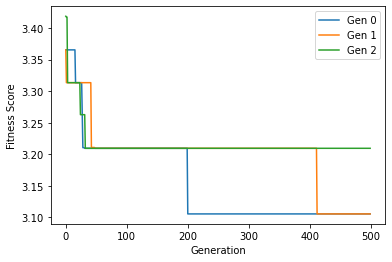

In [34]:
fig

This is a graph of fitness score (i.e. packing score) vs generation to show the progress the algorithm makes towards its best fitness.  
## Graphic Packing Results


In [35]:
%matplotlib inline
def plot_sheet(Cx, Sht, score, label, plot_label, nshts=1):
    """Create a plot showing placement of rectangles packed into a sheet.

    Parameters
    ----------
    Cx : Array
        2D array with packed part information.  Each row has
        container_ID, part_ID, x1, y1, x2 and y2.
        (x1, y1 = coordinates of part lower left corner,
         x2, y2 = coordinates of upper right corner
    Sht : List
        List with [x1, y1, x2, y2] for standard sheets
    score : float  (obsolete)
        Numeric metric describing packing performance.
    label : string  (obsolete)
        Text for metric. Used in conjunction with score. Example: "Waste"
    plot_label : string
        Test case or problem description
    nshts : int
        Total number of sheets to be plotted

    Returns
    -------
    None
    """
    colors = cm.get_cmap('tab20c')

    plt.rcParams.update({'figure.max_open_warning': 0})
    cID = str(Cx[0, 0])
    fig = plt.figure(cID, figsize=(10,7.5))
    ax = plt.gca()
    # plot container boundaries
    rect = patches.Rectangle(
        (0, 0), Sht[2], Sht[3], linewidth=.5, ec='k', fc='none')
    ax.add_patch(rect)     # Add the patch to the Axes

    # add container sheet, width and height labels 
    plt.text(.05, .96, f'Sheet {Cx[0, 0]+1:.0f} of {nshts}',
             fontsize=11, color='k',
              va='bottom', ha='left', transform=ax.transAxes)
    plt.text(0, .5, f'{Sht[3]:.3f}', fontsize=9, color='r',
              va='center', ha='right', rotation='vertical',
              transform=ax.transAxes)
    plt.text(.5, 0, f'{Sht[2]:.3f}', fontsize=9, color='r',
              ha='center', va='bottom', transform=ax.transAxes )
    now = str(datetime.datetime.now())
    plt.text(1, 0, now, fontsize=8, color='k',
              va='bottom', ha='right', transform=ax.transAxes);


    for c in Cx:  # c = [cID, pID, x1, y1, x2, y2]
        x = c[2]
        y = c[3]
        width = c[4] - c[2]
        height = c[5] - c[3]

        # color = 'w'        
        # uncomment next line if you want parts to be plotted in color
        color = colors(((c[1] - 1) * .0526) % 1)

        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, ec='k', fc=color)
        ax.add_patch(rect)
        
        if c[1] % 1 > 0:
            part_label = str(c[1])
        else:
            part_label = str(int(c[1]))
        
        offset = 5
        # add part dimensions
        if width >= height:
            ax.annotate(part_label, (x + width/2, y + height/2), ha='left',
                        va='center',
                         xytext=(offset, 0), textcoords='offset points',
                         color='b')
        else:
            ax.annotate(part_label, (x + width/2, y + height/2),
                         xytext=(0, 2*offset), textcoords='offset points',
                         rotation = 'vertical', color='b')
            
        ax.annotate(f'{height:.3g}', (x, y + height/2),
                    xytext=(offset, 0), textcoords='offset points',
                    fontsize=8, va='center', rotation = 'vertical')
        ax.annotate(f'{width:.3g}', (x + width/2, y + height),
                    xytext=(0, -1.5*offset), textcoords='offset points',
                    fontsize=8, ha='center')
        
    plt.title(plot_label)
    plt.axis('scaled')
    plt.axis('off')  # hide axes
    plt.tight_layout()  # adjusts axes so that everything shows
    
    return fig

In [36]:
def plot_solution(patterns, sht_width, sht_height, test_name):
    """Plot solution to a 2D bin packing problem. 
    
    Each sheet is plotted in a separate figure. 
    

    Parameters
    ----------
    patterns : list
        List with arrays defining each packed sheet. Each array row has 
        part_ID, part_width, part_length, part_area, x1 and y1. Where x1, y1
        are the coordinates of the lower left corner of the part.
    sht_width : float
        Sheet width (horizontal axis)
    sht_height : float
        Sheet height (vertical axis)
    test_name : string
        Description of test case or problem solved.

    """
    figs = []
    for sht in range(len(patterns)):
        pattern = patterns[sht]
        B = np.empty((0, 6), dtype=np.int32)  # initialize plotting array
        # B - array of packed parts (binID, partID, x1, y1, x2, y2 )
        for item in pattern:
            B = np.append(B, [[sht] + [item[0], item[4], item[5],
                                       item[1] + item[4],
                                       item[2] + item[5]]], axis=0)

        S = [0, 0, sht_width, sht_height]  # sheet dimensions
        B = B.astype(float)
        fig = plot_sheet(B, S, 0, '', test_name, len(patterns))
        figs.append(fig)
        
    return figs

In [37]:
def clean_kerfs(bins, sht_width, sht_height, kerf):
    """
    Before plotting or printing solutions, remove kerf allowances from parts
    and sheet dimensions. Also restores part ID's to their original state.

    Parameters
    ----------
    bins : list
        list of arrays representing packed bins. Parts have kerf allowances
        included.
    sht_width : float
        sheet width with kerf added.
    sht_height : float
        sheet height with kerf added.
    kerf : float
        saw blade allowance

    Returns
    -------
    bin_list : list
        list of arrays representing packed bins. Parts have kerf allowances
        removed.
    sht_width : TYPE
        sheet width without kerf
    sht_height : TYPE
        sheet height without kerf

    """
    for b in bins:
        for p in b:
            # remove kerfs
            p[1] -= kerf
            p[2] -= kerf
            # restore part ID's
            p[0] = p[0] // 100 if p[0] > 99 else p[0]
    
    return bins, sht_width-kerf, sht_height-kerf

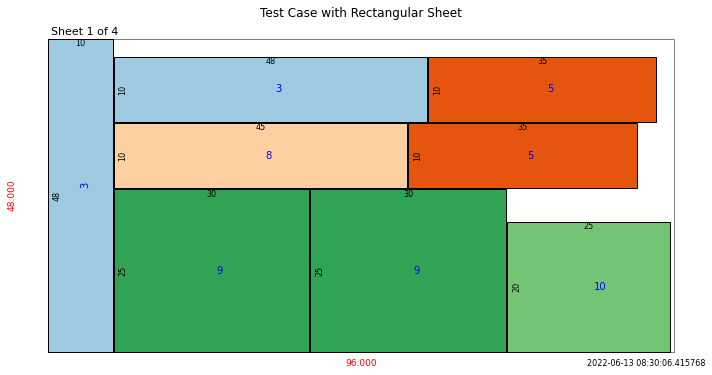

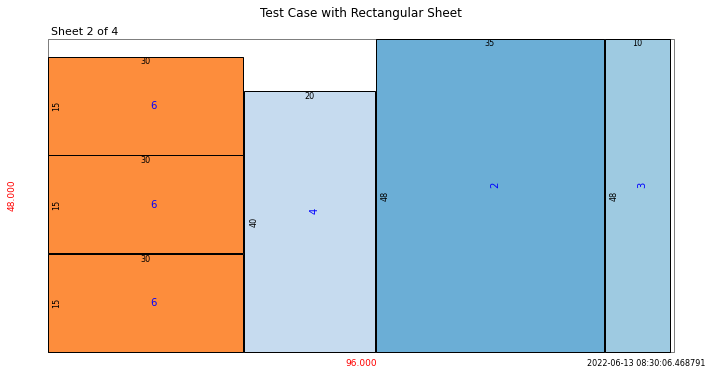

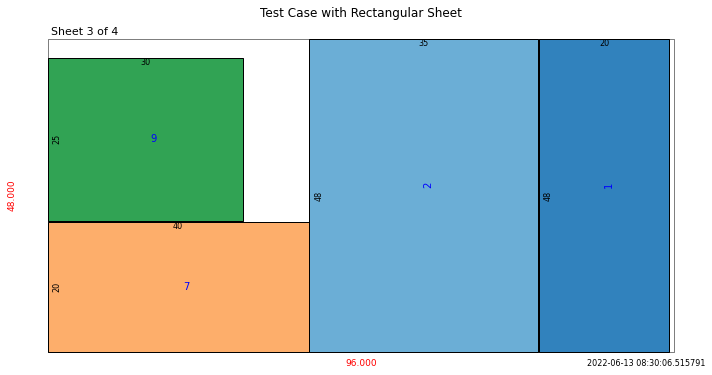

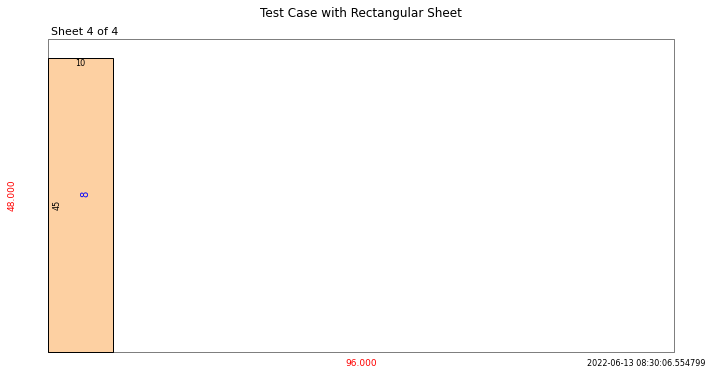

In [38]:
bin_list, sht_width, sht_height = clean_kerfs(best_bins, sht_width, sht_height, kerf)
plot_solution(bin_list, sht_width, sht_height, test_name);